## Lesson 3 - R version

Lesson 3 demonstrates how to visualise outputs from the simulation we ran in lesson 2. For a python version of this script see Lesson 3 - Python version. 



In [1]:
# Clear the workspace
rm(list=ls())

### Libraries 
First we load some libraries we are going to use for plotting. 

In [2]:
library(RColorBrewer)
library(ncdf4)
library(fields)


Warning message:
“package ‘RColorBrewer’ was built under R version 4.3.3”
Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 4.3.3”

Try help(fields) to get started.



#### Make some colours for plotting

In [3]:
cols = brewer.pal(8, 'Dark2')
cols_greens = brewer.pal(9, 'Greens')
cols_reds = brewer.pal(9, 'Reds')

### Load the FATES run

In [4]:
# load an example FATES run
fates = nc_open('/pscratch/sd/j/jneedham/elm_runs/fates-tute-runs/bci/fates-tutorial-bci-inventory_init.Edf989f750d-Fb8e4eee5.2024-07-23/run/fates-tutorial-bci-inventory_init.Edf989f750d-Fb8e4eee5.2024-07-23.sofar.nc')

# Extract some useful variables
lon = ncvar_get(fates, 'lon')
lat = ncvar_get(fates, 'lat')
time = ncvar_get(fates, 'time')/365
sizebins = ncvar_get(fates, 'fates_levscls')

nyears = ceiling(length(ncvar_get(fates, 'time'))/12)
tave_start = nyears*12 - 2*12 
tave_stop = nyears*12


### Biomass and number of plants through time

We start by just plotting the total AGB and number of plants through time. The history variable FATES_NPLANT_SZ is output along a size dimension. Here we just sum over that dimension. In lesson x we will untangle multiplexed dimensions to plot variables by pft or size or both. 

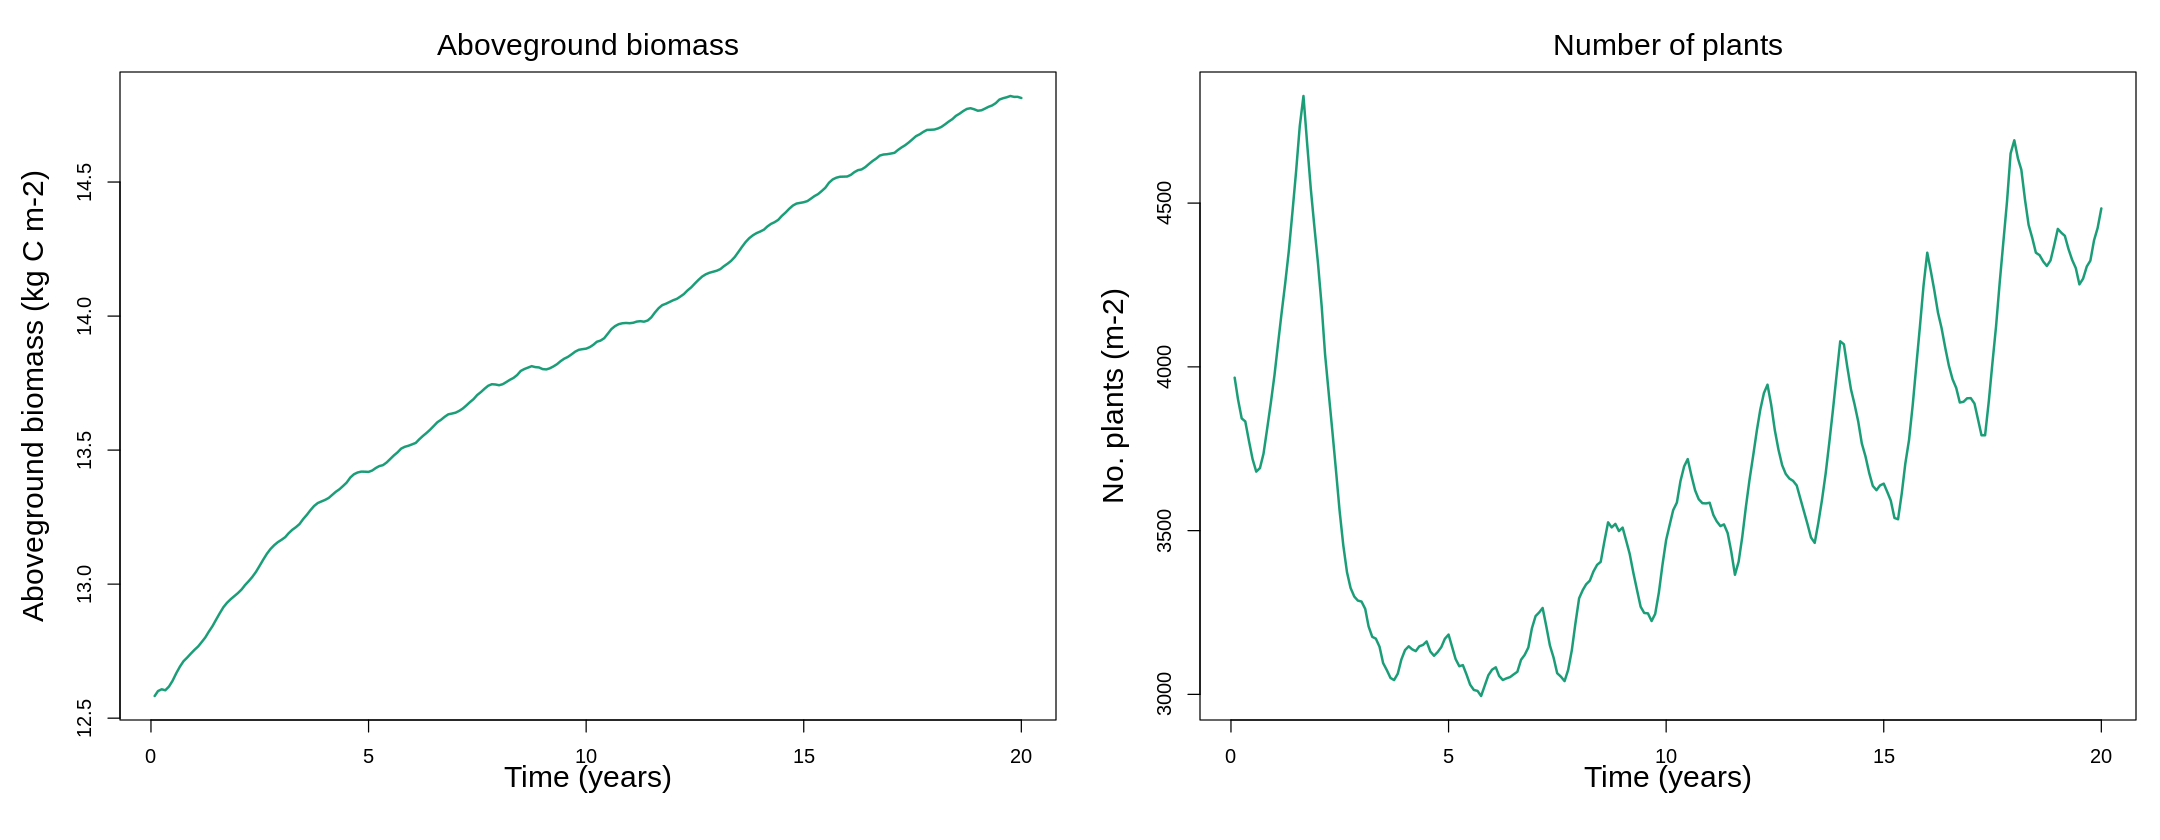

In [5]:
## Fig 1
options(repr.plot.width = 18)

par(mfrow=c(1,2), mar=c(5,5,3,1))

### Vegetation carbon through time
agb = ncvar_get(fates, 'FATES_VEGC_ABOVEGROUND')
#dim(agb)

fillvalue = ncatt_get(fates, 'FATES_VEGC_ABOVEGROUND', '_FillValue')
agb[agb == fillvalue$value] = NA

plot(time,agb, type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main = '')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('Aboveground biomass (kg C m-2)', side=2, line=3, cex=1.5)
mtext('Aboveground biomass', side=3, line=0.5, cex=1.5)

### Number of plants through time
nplant = ncvar_get(fates, 'FATES_NPLANT_SZ') * 10000
#dim(nplant)

fillvalue = ncatt_get(fates, 'FATES_NPLANT_SZ', '_FillValue')
nplant[nplant == fillvalue$value] = NA

# sum over the size dimension
nplant_time  = colSums(nplant)

plot(time, nplant_time, type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main='')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('No. plants (m-2)', side=2, line=3, cex=1.5)
mtext('Number of plants', side=3, line=0.5, cex=1.5)


Next we can plot both variables by size through time as a heat plot. 

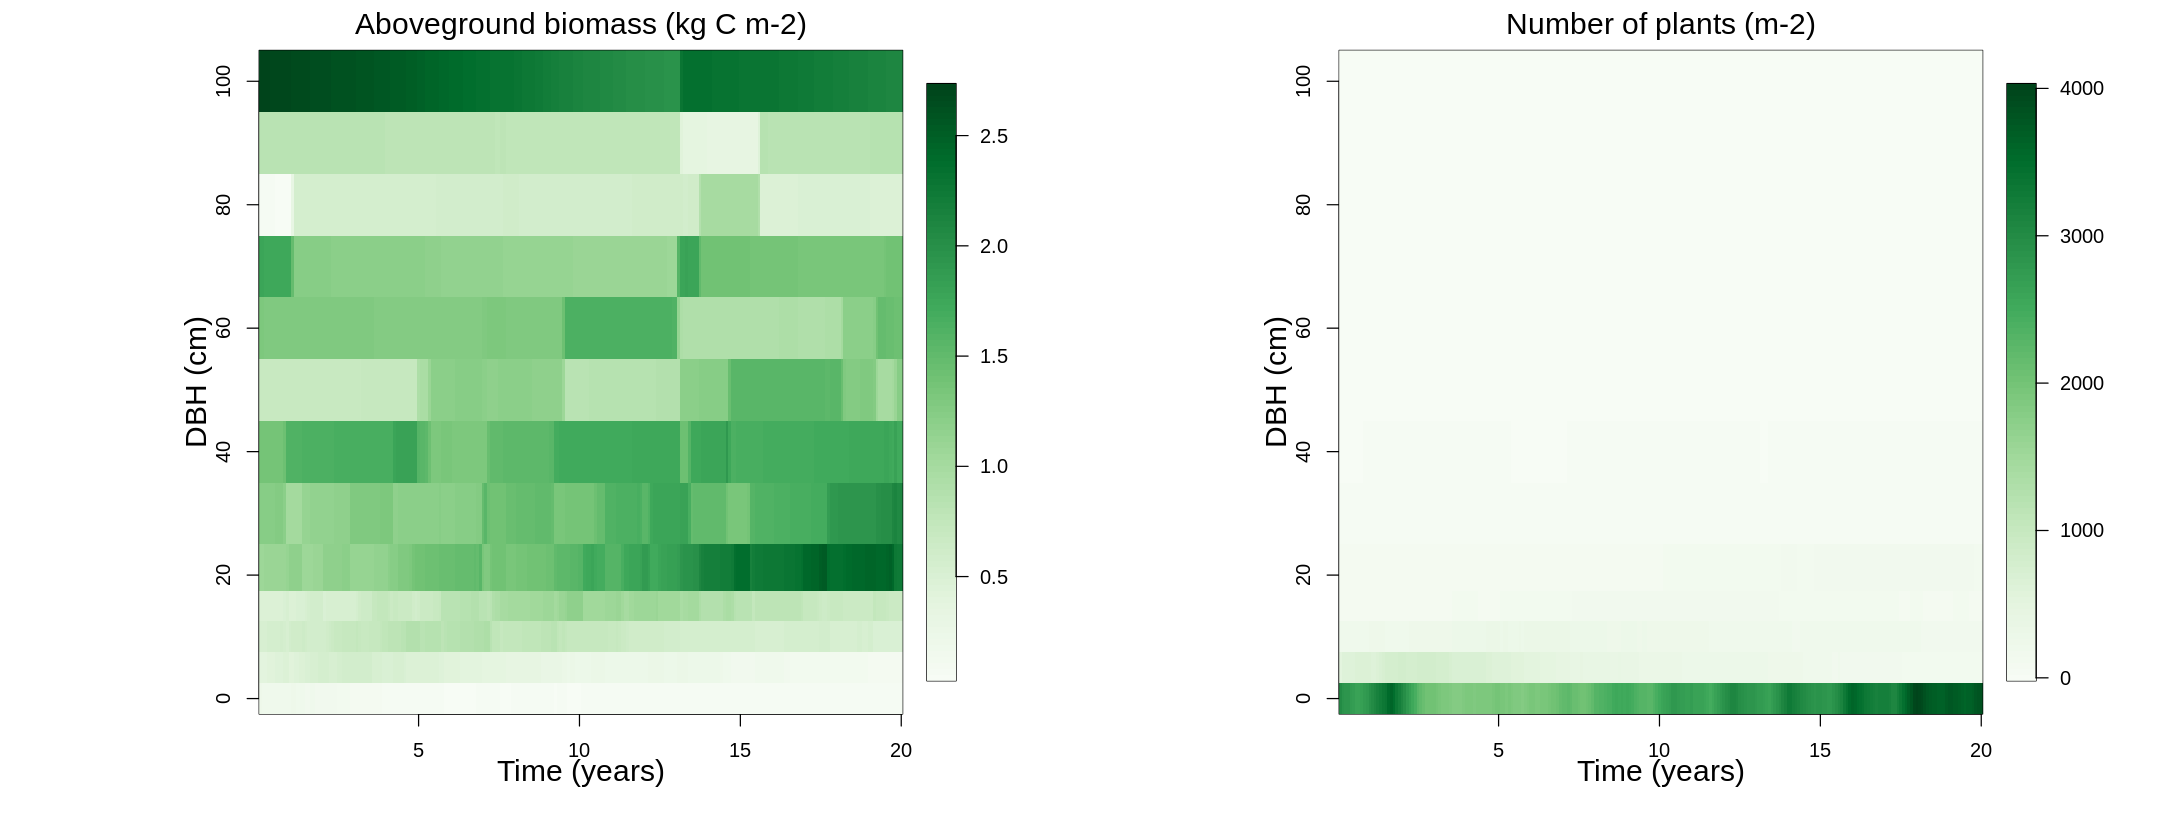

In [6]:
ncolors=100
green_col_pal=colorRampPalette(cols_greens)(ncolors)

agb = ncvar_get(fates, 'FATES_VEGC_ABOVEGROUND_SZ')
fillvalue = ncatt_get(fates, 'FATES_VEGC_ABOVEGROUND_SZ', '_FillValue')
agb[agb == fillvalue$value] = NA

par(mfrow=c(1,2), mar=c(5,4,2,1))

# 1. AGB
image.plot(x=time, y=sizebins, z=t(agb), xlab ='', ylab = '',
      main = '', col=green_col_pal)

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Aboveground biomass (kg C m-2)', side=3, line=0.5, cex=1.5)


# 1. Number of plants
image.plot(x=time, y=sizebins, z=t(nplant), xlab ='', ylab = '',
      main = '', col=green_col_pal)

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Number of plants (m-2)', side=3, line=0.5, cex=1.5)



#### Size distributions

To plot the size distribution we will average over the last ten years of the simulation. 
We divide by size bin width so that we are plotting number of plants per cm. 

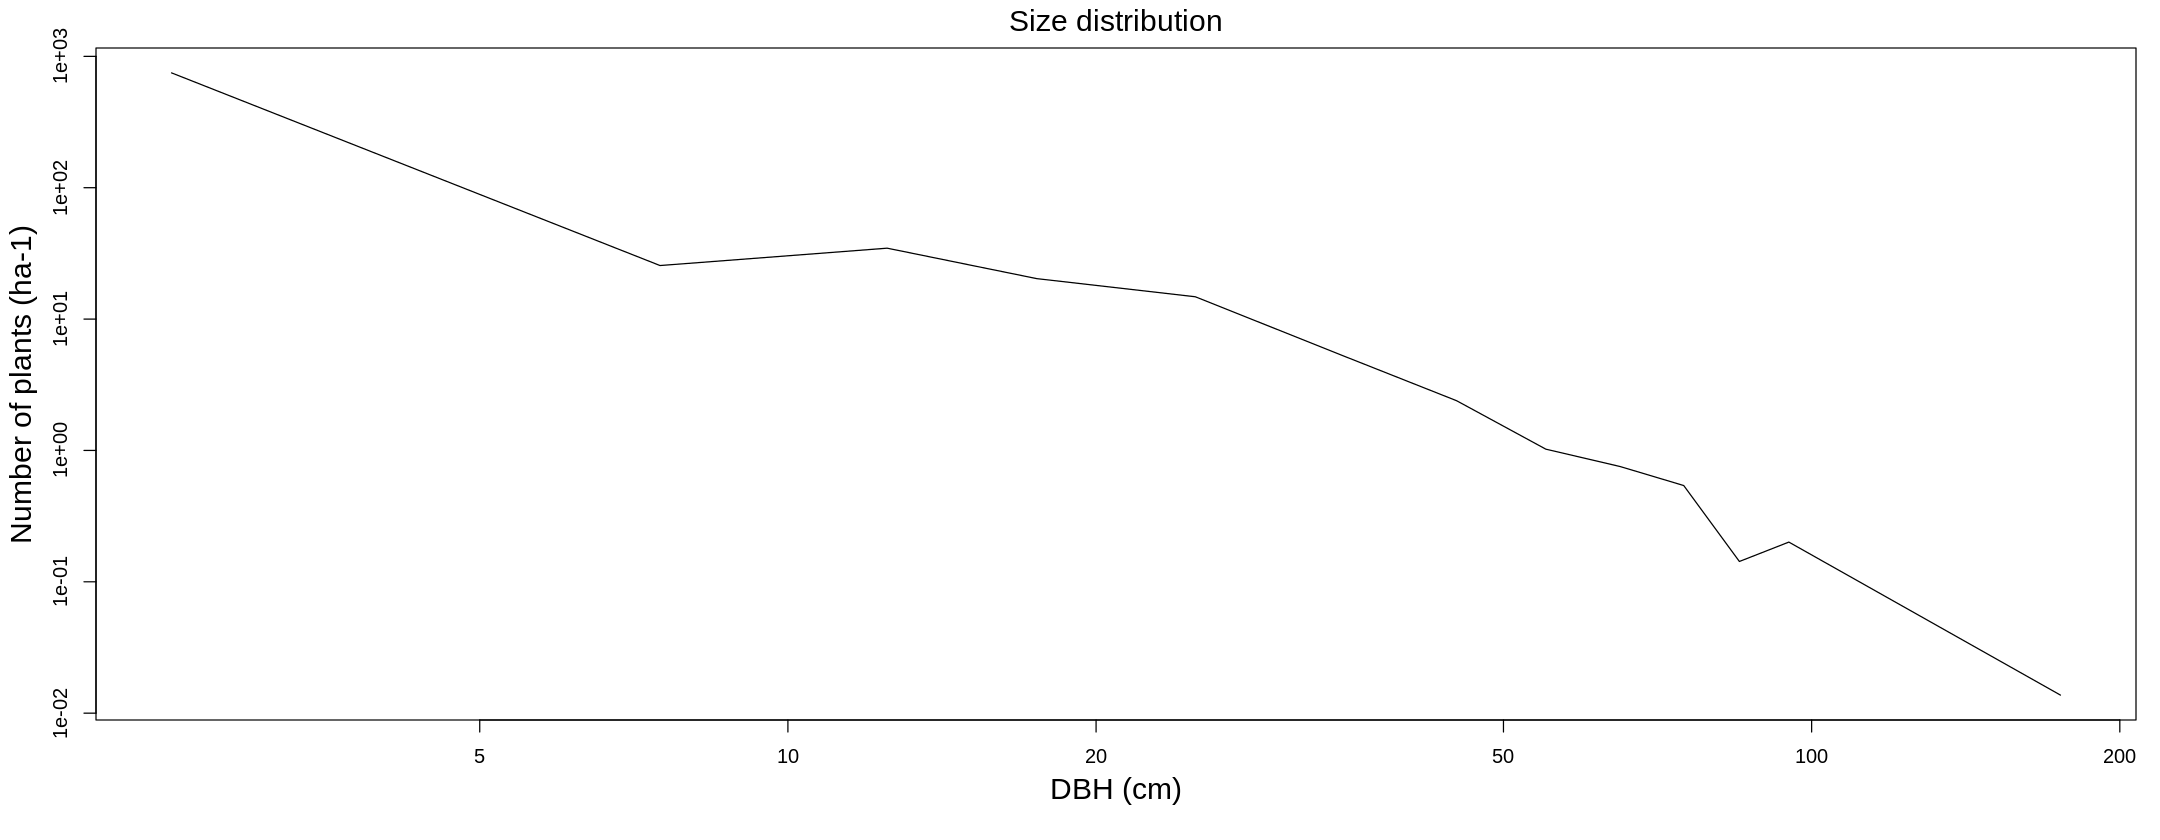

In [7]:
# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
sizebins_ex = c(sizebins, 250)
sizebin_mids = (sizebins_ex[-length(sizebins_ex)] + sizebins_ex[-1]) / 2
sizebin_widths = diff(sizebins_ex)

#fates_sd = np.squeeze(nplant[1:,])/fates_sizebin_widths

nplant_tave = rowMeans(nplant[,tave_start:tave_stop])
nplant_tave = nplant_tave/sizebin_widths

par(mfrow=c(1,1), mar=c(5,4,2,1))

plot(sizebin_mids, nplant_tave, log='xy', type = 'l', xlab='', ylab='', main='')
mtext('DBH (cm)', side=1, line =2.5, cex=1.5)
mtext('Number of plants (ha-1)', side=2, line = 2.5, cex = 1.5)
mtext('Size distribution', side=3, line = 0.5, cex=1.5)


#### GPP and NPP

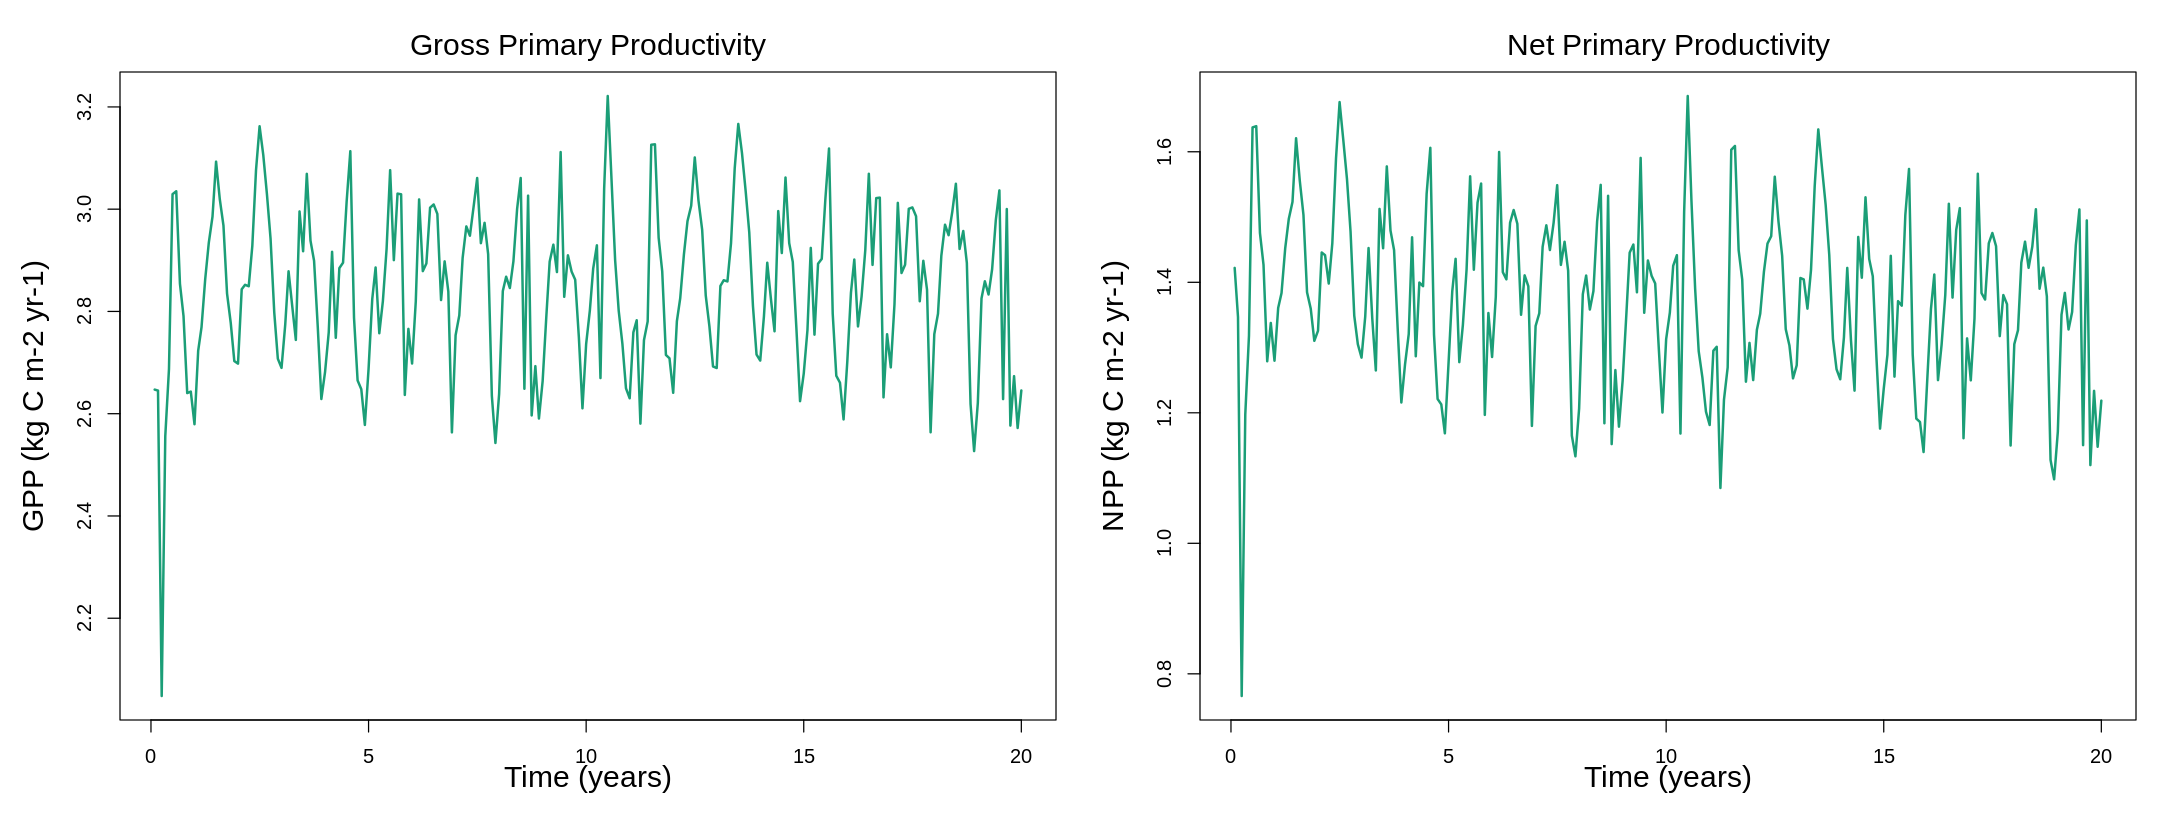

In [8]:
par(mfrow=c(1,2), mar=c(5,5,3,1))

### GPP
gpp = ncvar_get(fates, 'FATES_GPP') * 365 * 86400

fillvalue = ncatt_get(fates, 'FATES_GPP', '_FillValue')
gpp[gpp == fillvalue$value] = NA

plot(time,gpp, type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main = '')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('GPP (kg C m-2 yr-1)', side=2, line=3, cex=1.5)
mtext('Gross Primary Productivity', side=3, line=0.5, cex=1.5)


### NPP
npp = ncvar_get(fates, 'FATES_NPP') * 365 * 86400

fillvalue = ncatt_get(fates, 'FATES_NPP', '_FillValue')
npp[npp == fillvalue$value] = NA

plot(time,npp, type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main = '')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('NPP (kg C m-2 yr-1)', side=2, line=3, cex=1.5)
mtext('Net Primary Productivity', side=3, line=0.5, cex=1.5)


#### Growth and mortality

Growth and mortality are output as the absolute dbh increment in m and the number of plants that died. To convert them to growth we need to divide by the number of plants. 

In [9]:
nplant_canopy_sz = ncvar_get(fates, 'FATES_NPLANT_CANOPY_SZ')
nplant_ustory_sz = ncvar_get(fates, 'FATES_NPLANT_USTORY_SZ')

ddbh_canopy_sz = ncvar_get(fates, 'FATES_DDBH_CANOPY_SZ') * 100 # convert to cm 
ddbh_ustory_sz = ncvar_get(fates, 'FATES_DDBH_USTORY_SZ') * 100 # convert to cm

mort_canopy_sz = ncvar_get(fates, 'FATES_MORTALITY_CANOPY_SZ')
mort_ustory_sz = ncvar_get(fates, 'FATES_MORTALITY_USTORY_SZ')

ddbh_canopy_sz = ddbh_canopy_sz/nplant_canopy_sz
ddbh_ustory_sz = ddbh_ustory_sz/nplant_ustory_sz
mort_canopy_sz = mort_canopy_sz/nplant_canopy_sz
mort_ustory_sz = mort_ustory_sz/nplant_ustory_sz


In [13]:
mort_canopy_sz = ncvar_get(fates, 'FATES_MORTALITY_CANOPY_SZ')
mort_canopy_sz[13,1]

nplant_canopy_sz[13,1]

mort_canopy_sz[13,1] / nplant_canopy_sz[13,1]

[1] 1.779033e-06

[1] 0.0001204329

[1] 0.01477198

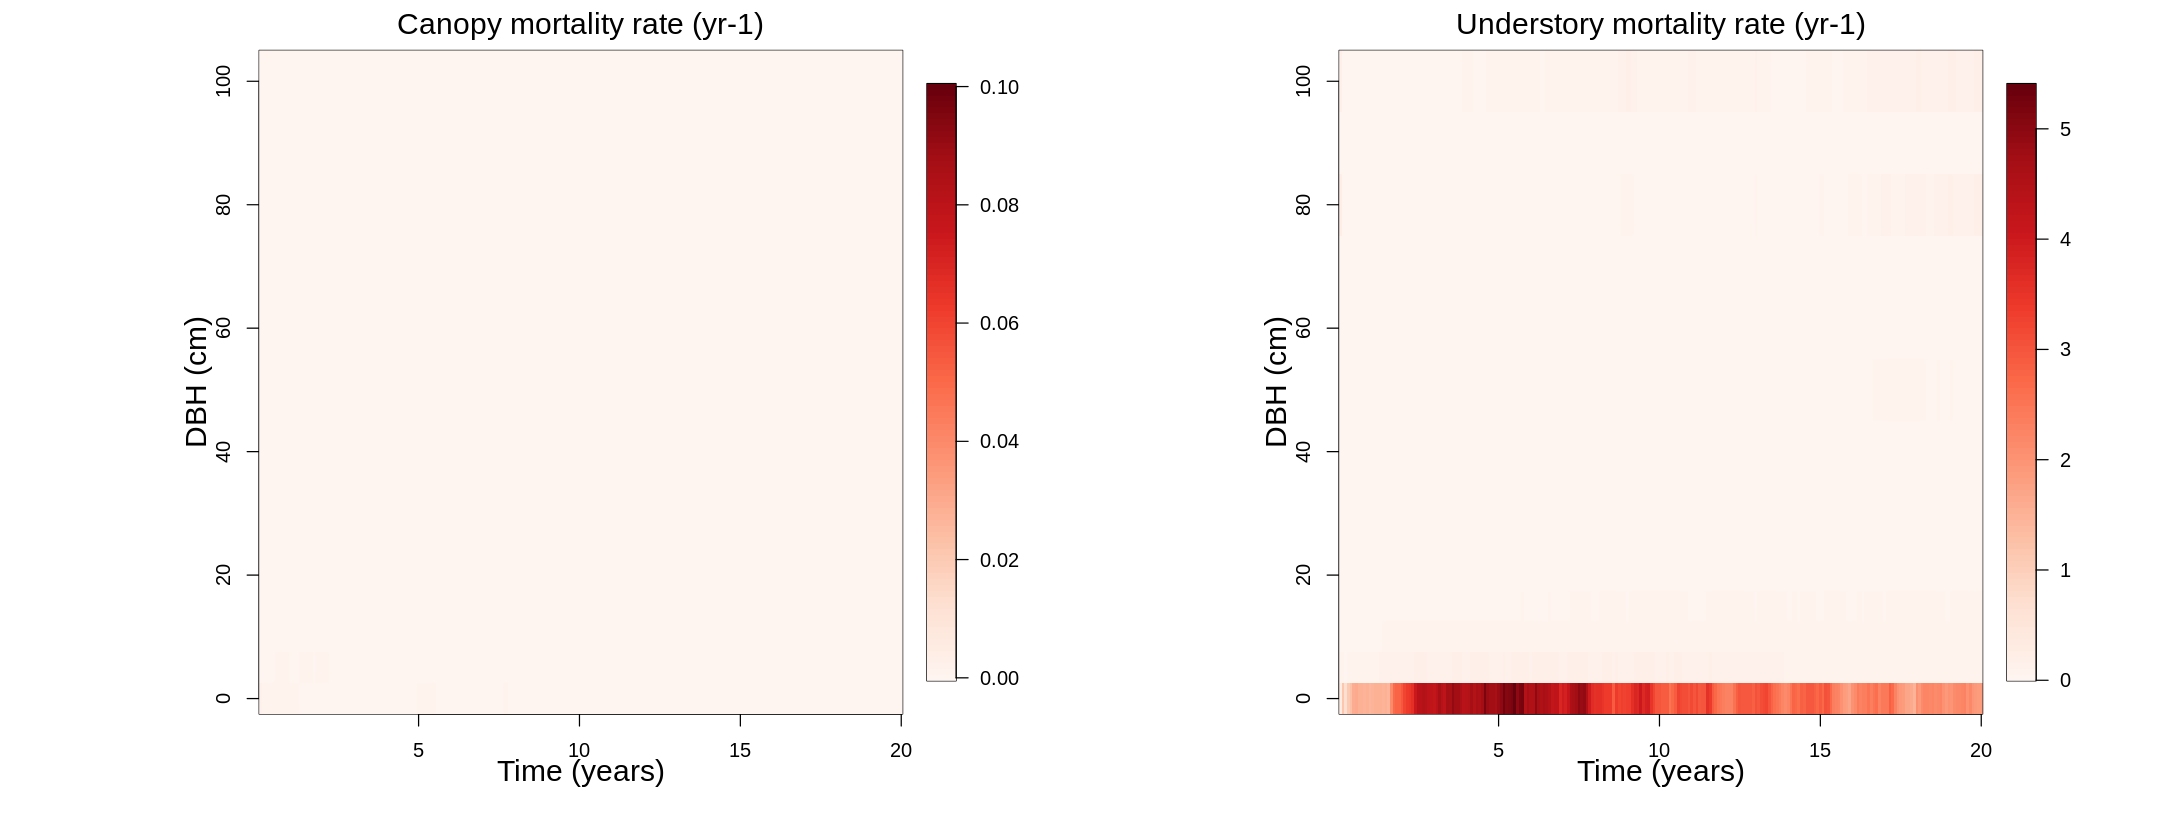

In [15]:
par(mfrow=c(1,2), mar=c(5,4,2,1))

# 3. canopy mortality 
ncolors=100
red_col_pal=colorRampPalette(cols_reds)(ncolors)

image.plot(x=time, y=sizebins, z=t(mort_canopy_sz), xlab ='', ylab = '',
      main = '', col=red_col_pal, zlim = c(0, 0.1))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy mortality rate (yr-1)', side=3, line=0.5, cex=1.5)

# Understory mortality 
image.plot(x=time, y=sizebins, z=t(mort_ustory_sz), xlab ='', ylab = '',
      main = '', col=red_col_pal)

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory mortality rate (yr-1)', side=3, line=0.5, cex=1.5)



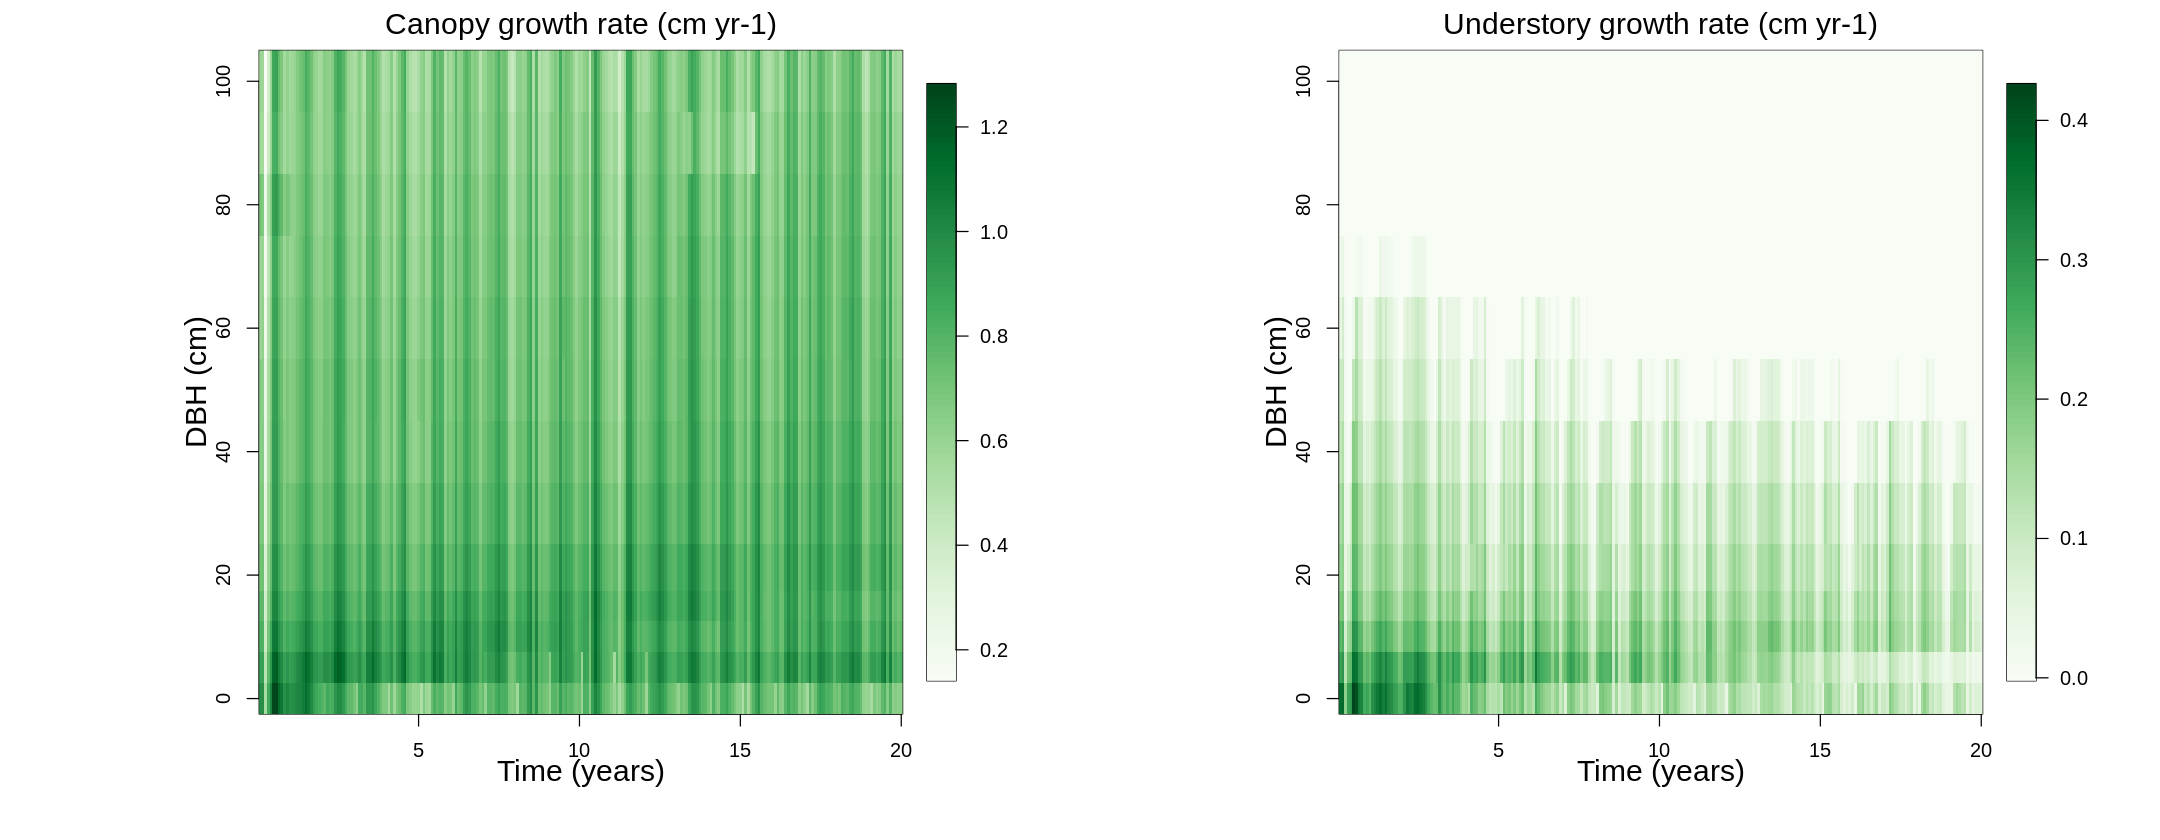

In [11]:
par(mfrow=c(1,2), mar=c(5,4,2,1))

# 3. canopy growth 
image.plot(x=time, y=sizebins, z=t(ddbh_canopy_sz), xlab ='', ylab = '',
      main = '', col=green_col_pal)

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy growth rate (cm yr-1)', side=3, line=0.5, cex=1.5)


# understory growth 
image.plot(x=time, y=sizebins, z=t(ddbh_ustory_sz), xlab ='', ylab = '',
      main = '', col=green_col_pal)

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory growth rate (cm yr-1)', side=3, line=0.5, cex=1.5)

